In [53]:
import os
import yaml
os.environ["BASE_DIR"] = "/work/FAC/FGSE/IDYST/tbeucler/downscaling"
BASE_DIR = os.environ["BASE_DIR"]
import json
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [54]:
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../../Scripts/Functions/Climate_Indices")

Loading the saved quick check trained model from Downscaling_Models/UNet_Deterministic_training_Dataset

In [55]:
model_path = os.path.join(BASE_DIR,"sasthana/Downscaling/Downscaling_Models/models_UNet/UNet_Deterministic_Combined_Dataset/combined_model_huber.pth")
training_checkpoint = torch.load(model_path, map_location=torch.device('cpu'))  # Moving model to CPU

In [56]:
#Checking the parameters and keys
print(type(training_checkpoint))

<class 'dict'>


In [57]:
#Checking all model parameters 
for key in training_checkpoint.keys():
    print(key)

epoch
model_state_dict
optimizer_state_dict
loss


In [58]:
#Importing UNet class from Unet.py
sys.path.append(os.path.join(BASE_DIR, "sasthana/Downscaling/Downscaling_Models/models_UNet/UNet_Deterministic_Combined_Dataset"))
from UNet import UNet #Importing Unet class
from Downscaling_Dataset_Prep import DownscalingDataset #for creating paired frames

In [59]:
#Creating model instance

In [60]:
model_instance= UNet(in_channels=5, out_channels=4)
model_instance.load_state_dict(training_checkpoint["model_state_dict"])
model_instance.eval()

UNet(
  (Encoder1): Encoder_Block(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Encoder2): Encoder_Block(
    (conv): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

In [61]:
#Scaled datasets for test set (2011-2020) :loading

In [62]:
precip_input = xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Combined_Chronological_Dataset", "combined_precip_input_test_chronological_scaled.nc"))
temp_input = xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Combined_Chronological_Dataset", "combined_temp_input_test_chronological_scaled.nc"))
tmin_input= xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Combined_Chronological_Dataset", "combined_tmin_input_test_chronological_scaled.nc"))
tmax_input= xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Combined_Chronological_Dataset", "combined_tmax_input_test_chronological_scaled.nc"))

In [63]:
precip_target = xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Combined_Chronological_Dataset", "combined_precip_target_test_chronological_scaled.nc"))
temp_target = xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Combined_Chronological_Dataset", "combined_temp_target_test_chronological_scaled.nc"))
tmin_target = xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Combined_Chronological_Dataset", "combined_tmin_target_test_chronological_scaled.nc"))
tmax_target = xr.open_dataset(os.path.join(BASE_DIR, "sasthana", "Downscaling", "Downscaling_Models", "Combined_Chronological_Dataset", "combined_tmax_target_test_chronological_scaled.nc"))

In [64]:
#Building the paired feature-target dataset; first loading individual and coverting them into images

In [65]:
# config used for training 
config_path = os.path.join(BASE_DIR, "sasthana/Downscaling/Downscaling_Models/models_UNet/UNet_Deterministic_Combined_Dataset/config.yaml")
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


In [66]:
# elevation
elevation_path = os.path.join(BASE_DIR, "sasthana/Downscaling/Downscaling_Models/elevation.tif")


merging DS before creating pairs,,,,wont work for individual files

In [67]:
inputs_merged = xr.merge([precip_input, temp_input, tmin_input, tmax_input])
targets_merged = xr.merge([precip_target, temp_target, tmin_target, tmax_target])

ds = DownscalingDataset(inputs_merged, targets_merged, config, elevation_path)

Loaded elevation from /work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/elevation.tif, shape: (255, 387)


In [68]:
#Checking shape of the ds instance 
print(f"Dataset shape: {ds.__len__()} samples") #Number of samples in the test set

Dataset shape: 3653 samples


In [69]:
#Checking shape of a random sample
input_img,target_img= ds[15] #14 th sample
print(f"Input image shape: {input_img.shape}")
print(f"Target image shape: {target_img.shape}")

Input image shape: torch.Size([5, 240, 370])
Target image shape: torch.Size([4, 240, 370])


In [70]:
from torch.utils.data import DataLoader

paired_ds = DataLoader(ds, batch_size=1, shuffle=False, num_workers=4)

In [71]:
for input_batch, target_batch in paired_ds:
    print(input_batch.shape)  # (1, 5, H, W)
    print(target_batch.shape) # (1, 4, H, W)
    break  # iterating once 

torch.Size([1, 5, 240, 370])
torch.Size([1, 4, 240, 370])


In [72]:
idx= 2008
input_img, target_img =ds[idx]
input_img= input_img.unsqueeze(0) # Adding batch dimension
date=str(inputs_merged.time.values[idx]) #What date?


In [73]:
model_instance.eval()
with torch.no_grad():
    pred_img = model_instance(input_img).squeeze(0).cpu().numpy()  
target_img = target_img.cpu().numpy()  

In [74]:
def descale_precip(x, min_val, max_val):
    return x * (max_val - min_val) + min_val

def descale_temp(x, mean, std):
    return x * std + mean

In [75]:
# Scaling params loading from the .json files
scaling_dir = os.path.join(BASE_DIR, "sasthana/Downscaling/Downscaling_Models/Combined_Chronological_Dataset")
rhiresd_params = json.load(open(os.path.join(scaling_dir, "combined_precip_scaling_params_chronological.json")))
tabsd_params   = json.load(open(os.path.join(scaling_dir, "combined_temp_scaling_params_chronological.json")))
tmind_params   = json.load(open(os.path.join(scaling_dir, "combined_tmin_scaling_params_chronological.json")))
tmaxd_params   = json.load(open(os.path.join(scaling_dir, "combined_tmax_scaling_params_chronological.json")))

In [76]:
pred_img_denorm = np.empty_like(pred_img)
target_img_denorm = np.empty_like(target_img)

pred_img_denorm[0] = descale_precip(pred_img[0], rhiresd_params["min"], rhiresd_params["max"])
pred_img_denorm[1] = descale_temp(pred_img[1], tabsd_params["mean"], tabsd_params["std"])
pred_img_denorm[2] = descale_temp(pred_img[2], tmind_params["mean"], tmind_params["std"])
pred_img_denorm[3] = descale_temp(pred_img[3], tmaxd_params["mean"], tmaxd_params["std"])

target_img_denorm[0] = descale_precip(target_img[0], rhiresd_params["min"], rhiresd_params["max"])
target_img_denorm[1] = descale_temp(target_img[1], tabsd_params["mean"], tabsd_params["std"])
target_img_denorm[2] = descale_temp(target_img[2], tmind_params["mean"], tmind_params["std"])
target_img_denorm[3] = descale_temp(target_img[3], tmaxd_params["mean"], tmaxd_params["std"])

In [77]:
#Loading coarsened files 
# Load coarse bicubic files
coarse_files = {
    "precip": BASE_DIR+"/sasthana/Downscaling/Downscaling_Models/Combined_Chronological_Dataset/precip_test_step2_coarse.nc",
    "temp":   BASE_DIR+"/sasthana/Downscaling/Downscaling_Models/Combined_Chronological_Dataset/temp_test_step2_coarse.nc",
    "tmin":   BASE_DIR+"/sasthana/Downscaling/Downscaling_Models/Combined_Chronological_Dataset/tmin_test_step2_coarse.nc",
    "tmax":   BASE_DIR+"/sasthana/Downscaling/Downscaling_Models/Combined_Chronological_Dataset/tmax_test_step2_coarse.nc"
}
coarse_ds = {var: xr.open_dataset(path) for var, path in coarse_files.items()}

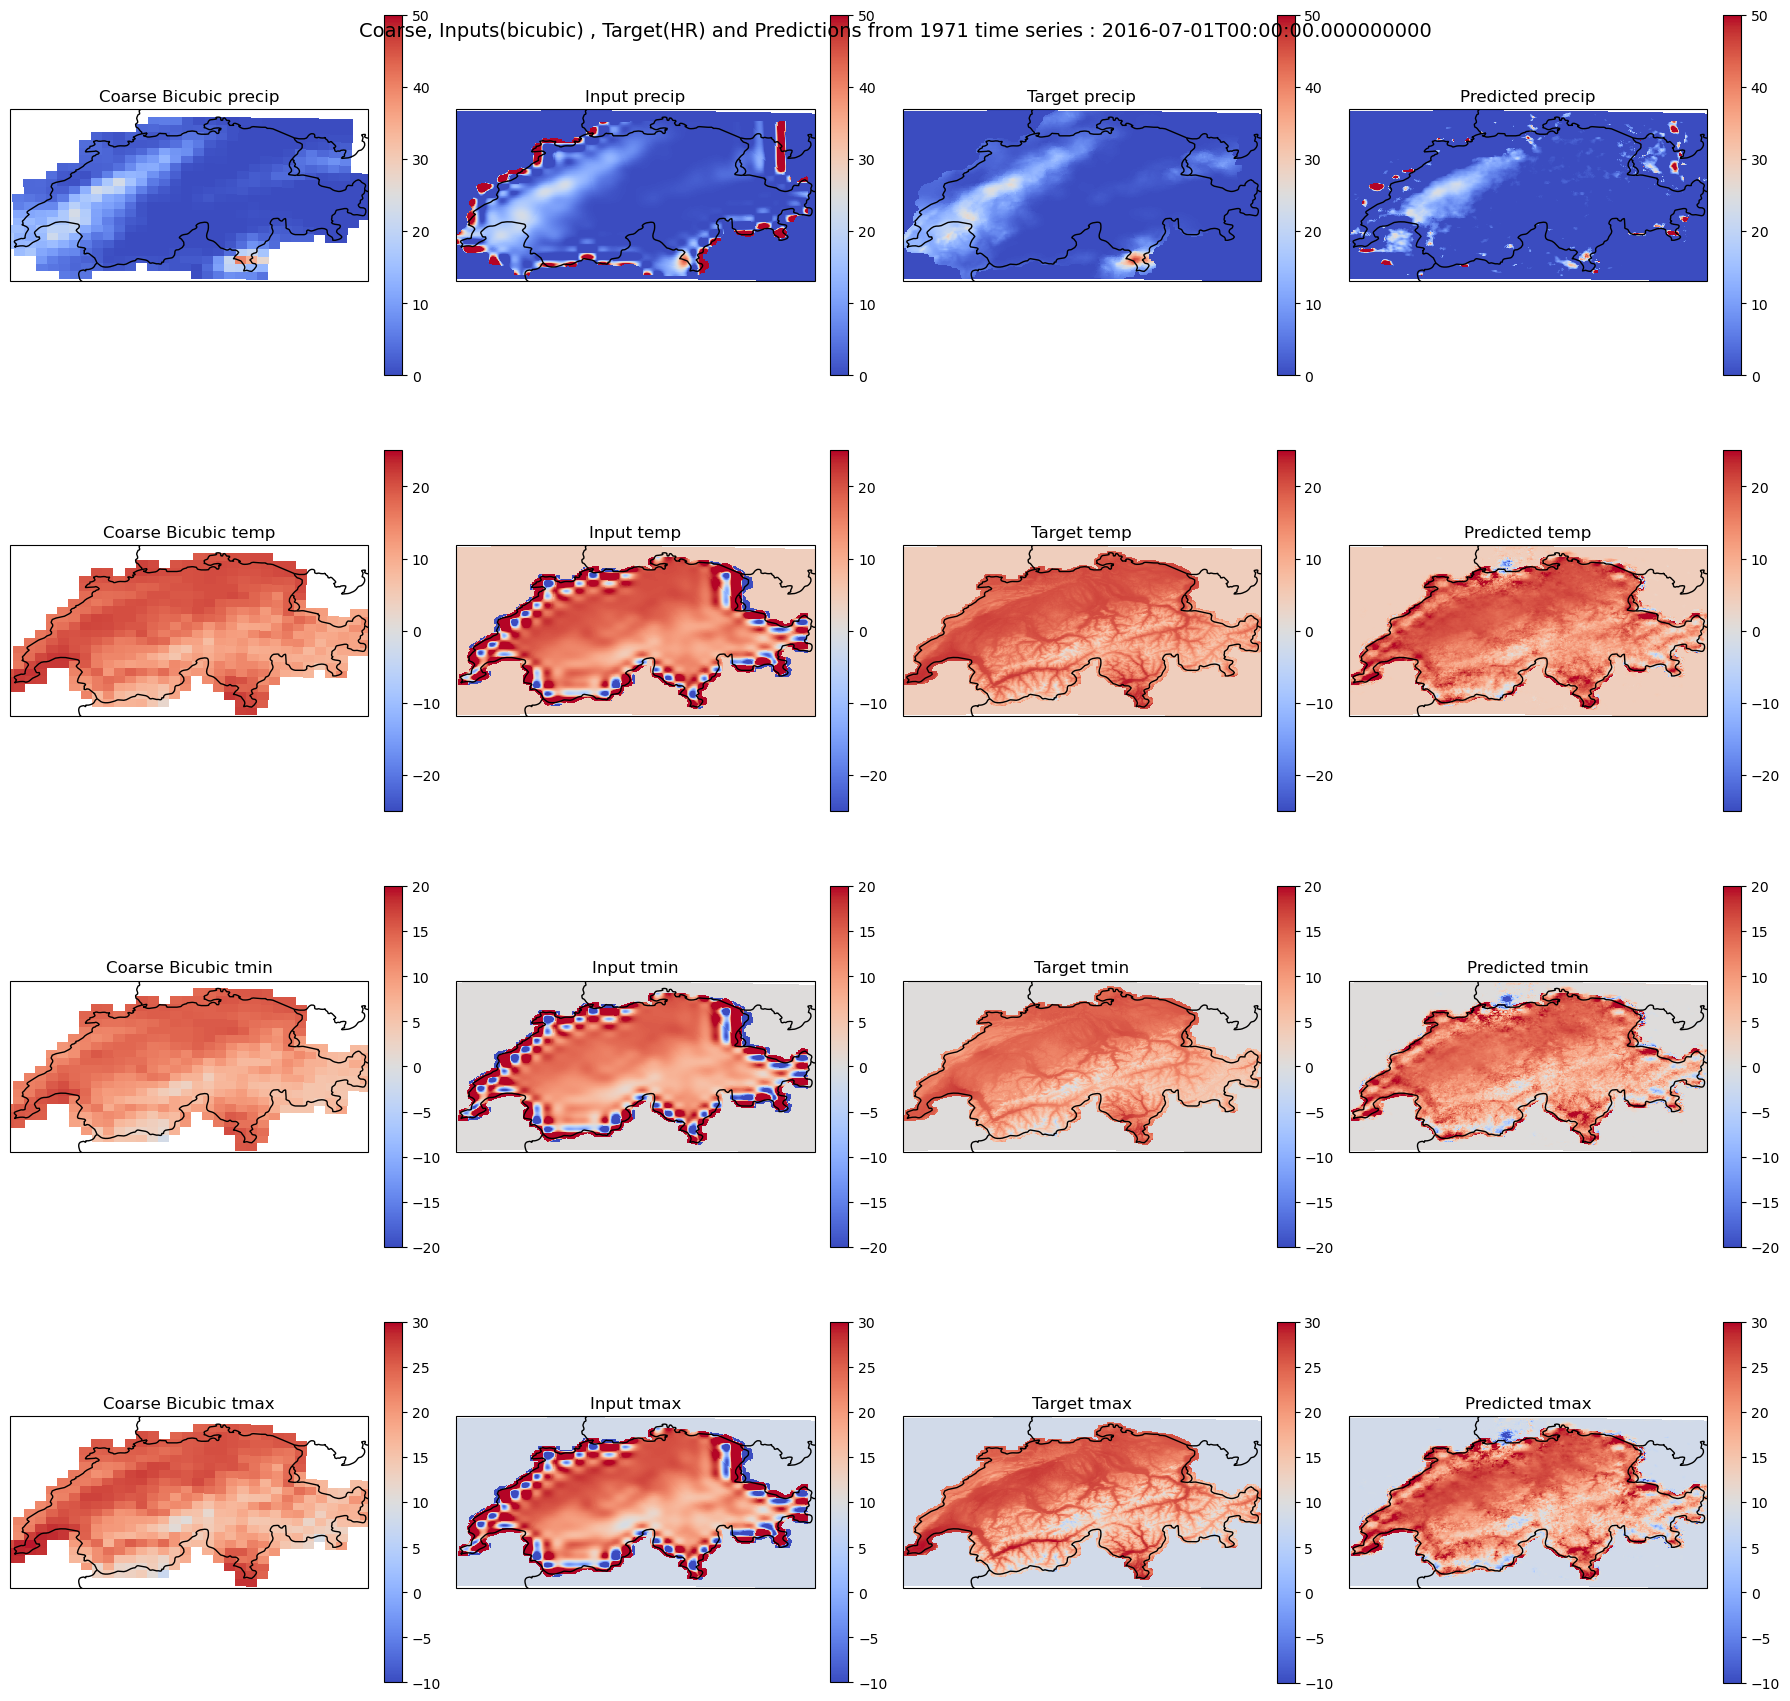

In [78]:
time_val = inputs_merged.time.values[idx]
lat = inputs_merged.lat.values
lon = inputs_merged.lon.values
var_names = ["precip", "temp", "tmin", "tmax"]
# Define fixed colorbar limits for each variable
vmin_dict = {"precip": 0, "temp": -25, "tmin": -20, "tmax": -10}
vmax_dict = {"precip": 50, "temp": 25, "tmin": 20, "tmax": 30}

swiss_extent = [5.9, 10.5, 45.7, 47.9]  

fig, axes = plt.subplots(4, 4, figsize=(18, 18), subplot_kw={'projection': ccrs.PlateCarree()})

input_img = input_img.squeeze(0)  
for i, var in enumerate(var_names):
    # COARSE IMAGE
    # Get coarse bicubic image for this variable
    coarse_var_name=var
    coarse_img = coarse_ds[var][var].sel(time=time_val).values
    coarse_lat= coarse_ds[var].lat.values
    coarse_lon= coarse_ds[var].lon.values

    #Input image : bicubic
    input_img_denorm = None
    if var == "precip":
        input_img_denorm = descale_precip(input_img[0].cpu().numpy(), rhiresd_params["min"], rhiresd_params["max"])
    elif var == "temp":
        input_img_denorm = descale_temp(input_img[1].cpu().numpy(), tabsd_params["mean"], tabsd_params["std"])
    elif var == "tmin":
        input_img_denorm = descale_temp(input_img[2].cpu().numpy(), tmind_params["mean"], tmind_params["std"])
    elif var == "tmax":
        input_img_denorm = descale_temp(input_img[3].cpu().numpy(), tmaxd_params["mean"], tmaxd_params["std"])

    vmin = vmin_dict[var]
    vmax = vmax_dict[var]

    #Plotting coarse image
    # Plotting coarse image
    ax = axes[i, 0]
    im = ax.pcolormesh(coarse_lon, coarse_lat, coarse_img, cmap='coolwarm', vmin=vmin, vmax=vmax, shading='auto', transform=ccrs.PlateCarree())
    ax.set_title(f"Coarse Bicubic {var}")
    ax.set_extent(swiss_extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)


    # Input
    ax = axes[i, 1]
    im = ax.pcolormesh(lon, lat, input_img_denorm, cmap='coolwarm', vmin=vmin, vmax=vmax, shading='auto', transform=ccrs.PlateCarree())
    ax.set_title(f"Input {var}")
    ax.set_extent(swiss_extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

    # Target
    ax = axes[i, 2]
    im = ax.pcolormesh(lon, lat, target_img_denorm[i], cmap='coolwarm', vmin=vmin, vmax=vmax, shading='auto', transform=ccrs.PlateCarree())
    ax.set_title(f"Target {var}")
    ax.set_extent(swiss_extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

    # Predicted
    ax = axes[i, 3]
    im = ax.pcolormesh(lon, lat, pred_img_denorm[i], cmap='coolwarm', vmin=vmin, vmax=vmax, shading='auto', transform=ccrs.PlateCarree())
    ax.set_title(f"Predicted {var}")
    ax.set_extent(swiss_extent, crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS)
    fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
plt.suptitle(f"Coarse, Inputs(bicubic) , Target(HR) and Predictions from 1971 time series : {date}", fontsize=14, y=0.95)
plt.tight_layout()
plt.show()

In [ ]:
#plt.savefig(BASE_DIR+ "/sasthana/Downscaling/Processing_and_Analysis_Scripts/Outputs/1_July_2016_unet_1971_2020.png", dpi=1000, bbox_inches='tight')
